In [1]:
import unet
import cv2
import tensorflow as tf
from tensorflow.keras import losses, metrics
import matplotlib.pyplot as plt

from preprocess.constants import SPLIT_SIZE

In [2]:
def normalize(input_image):
    input_image = tf.cast(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB), tf.float32) / 255.0
    #input_mask -= 1
    return input_image

In [3]:
LEARNING_RATE = 1e-3
unet_model = unet.build_model(*SPLIT_SIZE,
                              channels=3,
                              num_classes=3,
                              layer_depth=5,
                              filters_root=64,
                              padding="same"
                              )

unet.finalize_model(unet_model,
                    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=[metrics.SparseCategoricalAccuracy()],
                    auc=False,
                    learning_rate=LEARNING_RATE)

In [4]:
from joblib import load
data = load('data/data.pkl')

images, masks = data
images = [normalize(image) for image in images]
masks = [(tf.reshape(tf.cast(mask, tf.float32), (*SPLIT_SIZE,1))) for mask in masks]
#images, masks = shuffle(images, masks)
dataset = tf.data.Dataset.from_tensor_slices((images, masks))

In [5]:
#%load_ext tensorboard

In [6]:
import os
from unet import custom_objects
MODEL_PATH = 'model_data'

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
else:
    trainer = unet.Trainer('unet_test')
    trainer.fit(unet_model, dataset, epochs=16, batch_size=1)
    unet_model.save(MODEL_PATH)

model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
#model

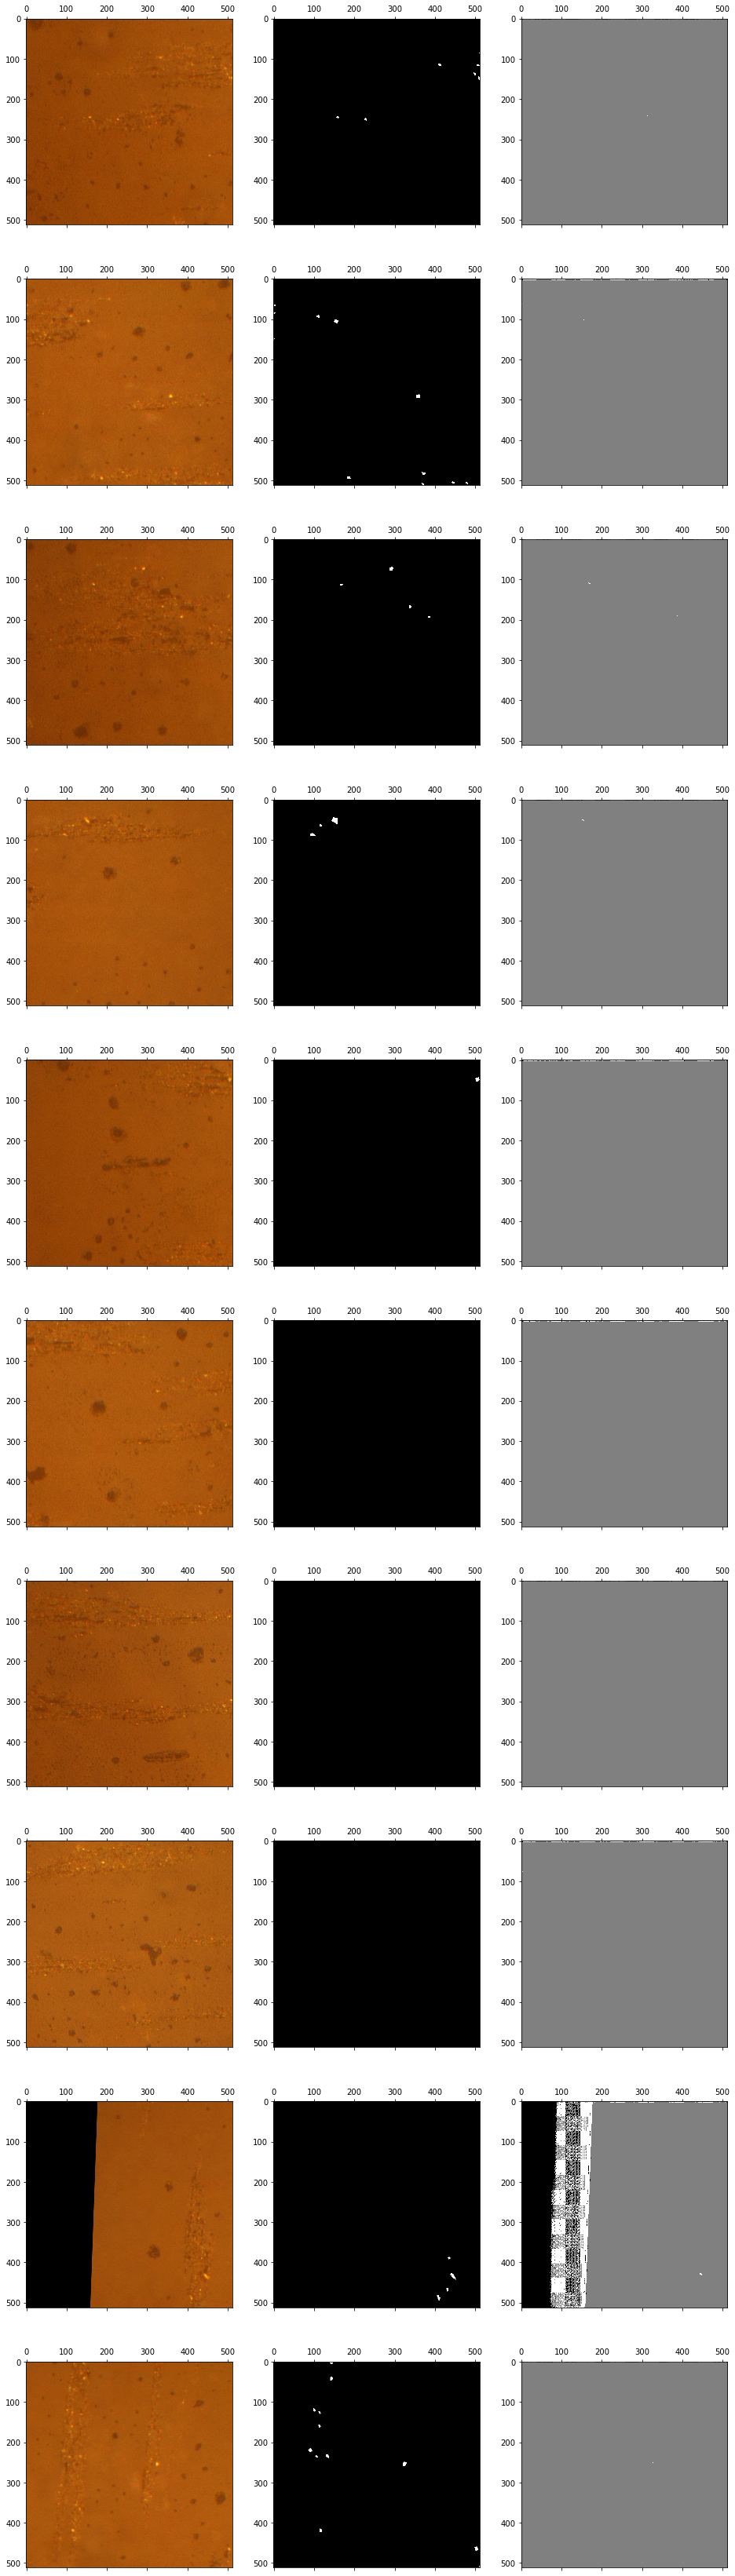

In [8]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(16, 6 * rows))
for ax, (image, label) in zip(axs, dataset.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0])
  ax[1].matshow(label[0, ..., 0], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")
